In [1]:
import sys
# !{sys.executable} -m pip install torch torchvision torchaudio
import lightgbm as lgb
import xgboost

from tqdm.notebook import trange, tqdm
from time import sleep, perf_counter

import os
from glob import glob
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter
from scipy.spatial import distance_matrix

# Reps
from alchemical_cms import genpaddedCMs
from dscribe.descriptors import SOAP
from dscribe.kernels import REMatchKernel
from mendeleev.fetch import fetch_table
from ase.io import read
from Element_PI import VariancePersist
from Element_PI import VariancePersistv1

from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, MACCSkeys
from openbabel import openbabel as ob
from openbabel import pybel

from xyz2graph import MolGraph, to_networkx_graph, to_plotly_figure
from plotly.offline import offline

#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200


Number of monomers is equivalent to monomers+CO2: True
Using the intersection of the sets of length: 400

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


# Find an automated way to determine the interaction sites of a dipeptide

In [2]:
# Useful data
ptable = fetch_table('elements').set_index('symbol')
Z={v:k for k,v in ptable['atomic_number'].to_dict().items()}

In [3]:
aa_dictog={'Glycine':"O=C(O)CN",
 'Arginine':"O=C(O)[C@H](CCCNC(N)=N)N",
 'Aspartic':"O=C(O)[C@H](CC(O)=O)N",
 'Alanine':"O=C(O)[C@H](C)N",
 'Threonine':"O=C(O)[C@H]([C@H](O)C)N",
 'Phenylalanine':"O=C(O)[C@H](CC1=CC=CC=C1)N",
 'Leucine':"O=C(O)[C@H](CC(C)C)N",
 'Lysine':"O=C(O)[C@H](CCCCN)N",
 'Histidine':"NC(c1cnc[nH]1)C(=O)O",# Wrong structure but use for code testing for now
 # 'Histidine':"O=C(O)[C@H](CC1=CNC=N1)N",
 'Cysteine':"O=C(O)[C@H](CS)N",
 'Glutamine':"O=C(O)[C@H](CCC(N)=O)N",
 'Methionine':"O=C(O)[C@H](CCSC)N",
 'Tryptophan':"O=C(O)[C@H](CC1=CNC2=CC=CC=C12)N",
 'Serine':"O=C(O)[C@H](CO)N",
 'Glutamic':"O=C(O)[C@H](CCC(O)=O)N",
 'Proline':"O=C(O)[C@H]1NCCC1",
 'Asparagine':"O=C(O)[C@H](CC(N)=O)N",
 'Valine':"O=C(O)[C@H](C(C)C)N",
 'Tyrosine':"O=C(O)[C@H](CC1=CC=C(C=C1)O)N",
 'Isoleucine':"O=C(O)[C@H]([C@@H](C)CC)N"}
aa_dict={}
for k,v in aa_dictog.items():
    if k!='Glycine':
        mol=Chem.MolFromSmiles(v)
        Chem.RemoveStereochemistry(mol)
        aa_dict[k]=Chem.MolToSmiles(mol)
    else:
        aa_dict[k]=v

In [4]:
# Find set of files
# monomerfiles=glob('./dipeptides_coordinates/AA_AA_*/final.xyz')
co2files=glob('./dipeptides_co2_coordinates/AA_AA_*/final.xyz')
# # Name check
# co2check=['_'.join(i.split('/')[-2].split('_')[:3]) for i in co2files]
# moncheck=['_'.join(i.split('/')[-2].split('_')[:4]) for i in monomerfiles]

y=pd.read_excel('400_dipeptides_interaction_energy.xlsx',usecols=[1,2],index_col=0)
y['keypair']=['_'.join(i.split('_')[:3]) for i in y.index]

# Pairs: 
# In the dehydration process,
# AA1 is the one that undergoes dehydroxylation
# and AA2 is the one that undergoes dehydrogenation
pairs=pd.DataFrame([(i[0].split(":")[0],i[0].split(":")[1].replace(" ","")) for i in pd.read_excel('400_dipeptides_interaction_energy.xlsx', 'Sheet2',header=None).values]).set_index(0)

ptable = fetch_table('elements').set_index('symbol')
AAs=list(set(sum([i[0].split('-') for i in pairs.values],[])))

monomerfiles={}
for k,v in pairs.to_dict()[1].items():
    path=f'./dipeptides_coordinates/{k}/final.xyz'
    if os.path.exists(path):
        monomerfiles[v]=path
        
        
        
co2paths={}
for k,v in pairs.to_dict()[1].items():
    path=glob(f'./dipeptides_co2_coordinates/{k}_*/final.xyz')[0]
    if os.path.exists(path):
        co2paths[v]=path        

In [5]:

# # Create the MolGraph object
# mg = MolGraph()

# # Read the data from the .xyz file
# mg.read_xyz(co2files[0])

# # Create the Plotly figure object
# fig = to_plotly_figure(mg)

# # Plot the figure
# offline.plot(fig)

# # Convert the molecular graph to the NetworkX graph
# G = to_networkx_graph(mg)

In [6]:
def genxyz(filename):
    """
    Generate xyz file as numpy arrays
    
    parameters
    ----------
    filename: str
        Path to xyz file
        
    returns
    -------
    atoms: np.ndarray (str)
    
    xyz: np.ndarray (float)
    """
    file=np.genfromtxt(filename,skip_header=2,dtype=str)

    atoms=file[:,0]
    xyz=file[:,1:].astype(float)
    
    return atoms, xyz


def gendistmat(xyz):
    """
    Generate distance matrix from xyz array
    
    parameters
    ----------
    xyz: np.ndarray
    
    returns
    -------
    D: np.ndarray
    """
    atoms=xyz[0]
    xyz=xyz[1]
    D=distance_matrix(xyz,xyz)
    D=pd.DataFrame(D)
    return atoms,D

def closest(atms,distmat):
    clsdf=distmat.iloc[-3:,:-3].T.idxmin().to_frame()
    close=atms[clsdf.values]
    clsdf['atoms']=close
    clsdf=clsdf.rename(columns={0:'idx'})
    if dict(Counter(atms[clsdf.index]))=={'C':1,'O':2}:        
        return clsdf
    else:
        return None

In [7]:
inter_dict={pairs.to_dict()[1]['_'.join(i.split('/')[-2].split('_')[:3])]:closest(*gendistmat(genxyz(i))) for i in co2files}

In [8]:

co2dipepgraphs={}
co2mgs={}
for k,v in co2paths.items():
    # Create the MolGraph object
    mg = MolGraph()

    # Read the data from the .xyz file
    mg.read_xyz(v)
    co2mgs[k]=mg
    # Convert the molecular graph to the NetworkX graph
    G = to_networkx_graph(mg)
    co2dipepgraphs[k]=G
    
dipepgraphs={}    
mgs={}
for k,v in monomerfiles.items():
    # Create the MolGraph object
    mg = MolGraph()

    # Read the data from the .xyz file
    mg.read_xyz(v)
    mgs[k]=mg
    # Convert the molecular graph to the NetworkX graph
    G = to_networkx_graph(mg)
    dipepgraphs[k]=G    
# fig = to_plotly_figure(mgs['Histidine-Alanine'])
# offline.plot(fig)

In [9]:
# define the function for coverting rdkit object to networkx object -----------     
# From: https://gist.github.com/fangkuoyu/dc785218e5d4d94c752e80f1aaba4fad
def mol_to_nx(mol):
    mol=AllChem.AddHs(mol)
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G


def mol_to_nx_noHs(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G

def draw_aminoacid(G):
    attrkeys=list(dict(G.nodes(data=True)).values())[0].keys()
    if 'element' in attrkeys:
        attkey='element'
        
    else:
        attkey='atom_symbol'
    atom = nx.get_node_attributes(G, attkey)
    color_map = {'C': '#696969',
                 'O': 'red',
                 'N': 'blue',
                 'H': '#F2F2F2',
                 'S': 'yellow'
                }

    colors = []
    for idx in G.nodes():
        if (G.nodes[idx][attkey] in color_map):
            colors.append(color_map[G.nodes[idx][attkey]])            
        else:
            colors.append('gray')

    nx.draw_spring(G,
            labels=atom,
            with_labels = True,
            node_color=colors,
            node_size=800)

    plt.show()


In [10]:
def MolFromGraphs(G):
    node_list=dict(G.nodes(data=True))
    adjacency_matrix=nx.adjacency_matrix(G).toarray()
    # create empty editable mol object
    mol = Chem.RWMol()

    # add atoms to mol and keep track of index
    node_to_idx = {}
    for i in range(len(node_list)):
        a = Chem.Atom(node_list[i]['element'])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    # add bonds between adjacent atoms
    for ix, iy in G.edges():
        nix=node_list[ix]
        niy=node_list[iy]
        
        single=np.round((ptable.loc[nix['element']]['covalent_radius_cordero']+ptable.loc[niy['element']]['covalent_radius_cordero'])/100,2)
        double=np.round((ptable.loc[nix['element']]['covalent_radius_pyykko_double']+ptable.loc[niy['element']]['covalent_radius_pyykko_double'])/100,2)
        bl=np.round(np.linalg.norm(np.array(nix['xyz'])-np.array(niy['xyz'])),2)
        if np.isclose(single,bl,atol=1e-1):
            # if nix['element']=='N' or niy['element']=='N':
            #     print(ix,iy,nix['element'],niy['element'])
            #     print('Single',single,double,bl,np.isclose(single,bl),np.isclose(double,bl,atol=1e-1))    
            #     print()
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif np.isclose(double,bl,atol=1e-1):
            # print(ix,iy,nix['element'],niy['element'])
            # print('Double',single,double,bl)    
            # print()
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            
        else:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)            
            

    mol = mol.GetMol()
    return mol

In [11]:
# MolFromGraphs(dipepgraphs[k])

In [12]:
# Make amino acid A (one that undergoes dehydroxylation)
dehydroxy={}
for k,v in aa_dict.items():
    m=Chem.MolFromSmiles(v)
    substructure = Chem.MolFromSmiles("O=C(O)CN")
    matches=m.GetSubstructMatches(substructure)


    n=Chem.EditableMol(m)
    for atom in m.GetAtoms():
        for i in sum(matches,()):
            if atom.GetIdx()==i and atom.GetSymbol()=='O' and atom.GetTotalNumHs()==1: 
                n.RemoveAtom(atom.GetIdx())
    m=n.GetMol()
    dehydroxy[k]=m
    
    
    
dehydrogen={}
for idx,(k,v) in enumerate(aa_dict.items()):
    m=Chem.MolFromSmiles(v)
    substructure = Chem.MolFromSmiles("O=C(O)CN")
    matches=m.GetSubstructMatches(substructure)


    for atom in m.GetAtoms():
        for i in sum(matches,()):
            if atom.GetIdx()==i and atom.GetSymbol()=='N': 
                atom.SetNoImplicit(True)
                if k!='Proline':
                    atom.SetNumExplicitHs(1)
    dehydrogen[k]=m    
# Draw.MolsToGridImage(dehydroxy.values(),molsPerRow=5, subImgSize=(300,300),legends=dehydroxy.keys())    
# Draw.MolsToGridImage(dehydrogen.values(),molsPerRow=5, subImgSize=(300,300),legends=dehydrogen.keys())    

In [13]:
# m=Chem.MolFromSmiles(aa_dict['Lysine'])
# substructure = Chem.MolFromSmiles("O=C(O)CN")
# matches=m.GetSubstructMatches(substructure)
# n=Chem.EditableMol(m)
# for atom in m.GetAtoms():
#     for i in sum(matches,()):
#         if atom.GetIdx()==i and atom.GetSymbol()=='N': 
#             print(atom.SetNoImplicit(True))
#             print(atom.SetNumExplicitHs(1))
#             print(atom.GetIdx(),atom.GetSymbol(),atom.GetTotalNumHs())


In [14]:
mols={}
for k,m in monomerfiles.items():
    mol=Chem.AddHs(Chem.MolFromSmiles(list(pybel.readfile('xyz',m))[0].write().split('\t')[0]))
    Chem.RemoveStereochemistry(mol)
    mols[k]=mol


aa_mols={k:Chem.MolFromSmiles(v) for k,v in aa_dict.items()}
g=Draw.MolsToGridImage(list(mols.values()),molsPerRow=10, subImgSize=(200,200),maxMols=400,legends=mols.keys())
# with open("dipeptides.png", "wb") as png:
#     png.write(g.data)
# Draw.MolsToGridImage(list(aa_mols.values()),molsPerRow=5, subImgSize=(300,300),legends=list(aa_mols.keys()))

In [15]:
hist_check={k:v for k,v in mols.items() if 'Histidine' in k}

In [16]:
# g=Draw.MolsToGridImage(hist_check.values(),molsPerRow=5, subImgSize=(300,300),legends=hist_check.keys())   
# with open("histidines.png", "wb") as png:
#     png.write(g.data)


In [17]:
# Check interaction positions
qc=[]
for idx,(k,v) in enumerate(dipepgraphs.items()):
    inds=[]
    atoms=[]
    for atom in MolFromGraphs(v).GetAtoms():
        if atom.GetIdx() in inter_dict[k]['idx'].values:
            inds.append(atom.GetIdx())
            atoms.append(atom.GetSymbol())
    if set(inter_dict[k].atoms.values)==set(atoms) and set(inter_dict[k].idx.values)==set(inds):
        qc.append(True)
    else:
        qc.append(False)


In [18]:
    
# Check aromaticity
arom={}
for k,v in dipepgraphs.items():
    m=MolFromGraphs(v)
    # if len(list(mols[k].GetAromaticAtoms()))!=0:
    for atom in m.GetAtoms():
        for rdatom in mols[k].GetAtoms():
            if atom.GetIdx()==rdatom.GetIdx() and atom.GetSymbol()==rdatom.GetSymbol():                        
                for mbonds,rdbonds in zip(atom.GetBonds(),rdatom.GetBonds()):
                    mbonds.SetBondType(rdbonds.GetBondType())
    arom[k]=m


In [56]:
interaction_AA={}
if all(qc):
    for k,m in arom.items():
        # print(k)
        Chem.rdmolops.Cleanup(m)
        A,B=k.split('-')
        
        subA = Chem.AddHs(dehydroxy[A])
        matchA=m.GetSubstructMatches(subA)
        subB = Chem.AddHs(dehydrogen[B])
        matchB=m.GetSubstructMatches(subB)
        
        
        inter=[]
        for idx,i in enumerate(inter_dict[k].idx.values):
            atomsymb=m.GetAtomWithIdx(int(i)).GetSymbol()
            if atomsymb==inter_dict[k].atoms.values[idx]:
                if i in sum(matchA,()):
                    inter.append((A,i,atomsymb))
                if i in sum(matchB,()):
                    inter.append((B,i,atomsymb))    
                    
        if len(inter)<3:
            Chem.rdmolops.Cleanup(m)
            m=Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(m)))
            Chem.Kekulize(m)
            subA = Chem.AddHs(dehydroxy[A])
            Chem.Kekulize(subA)
            matchA=m.GetSubstructMatches(subA)
            subB = Chem.AddHs(dehydrogen[B])
            Chem.Kekulize(subB)
            matchB=m.GetSubstructMatches(subB)

            inter=[]
            for idx,i in enumerate(inter_dict[k].idx.values):
                atomsymb=m.GetAtomWithIdx(int(i)).GetSymbol()
                # if m.GetAtomWithIdx(int(i)).GetSymbol()==inter_dict[k].atoms.values[idx]:
                if i in sum(matchA,()):
                    inter.append((A,i,atomsymb))
                if i in sum(matchB,()):
                    inter.append((B,i,atomsymb))                                         
            
            
        interaction_AA[k]=inter


In [20]:
for k,v in interaction_AA.items():
    if len(v)<3:
        print(k)
        break
        
scuffed=[k for k,v in interaction_AA.items() if len(v)<3]
print(len(scuffed))
print(scuffed)

0
[]


In [21]:
# k=scuffed[0]
# m=arom[k]
# Chem.rdmolops.Cleanup(m)
# A,B=k.split('-')

# subA = Chem.AddHs(dehydroxy[A])
# matchA=m.GetSubstructMatches(subA)
# subB = Chem.AddHs(dehydrogen[B])
# matchB=m.GetSubstructMatches(subB)


# inter=[]
# for idx,i in enumerate(inter_dict[k].idx.values):
#     if m.GetAtomWithIdx(int(i)).GetSymbol()==inter_dict[k].atoms.values[idx]:
#         if i in sum(matchA,()):
#             inter.append('A')
#         if i in sum(matchB,()):
#             inter.append('B')
# print(inter)


# m=arom[k]

# Chem.rdmolops.Cleanup(m)
# m=Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(m)))
# Chem.Kekulize(m)
# subA = Chem.AddHs(dehydroxy[A])
# Chem.Kekulize(subA)
# matchA=m.GetSubstructMatches(subA)
# subB = Chem.AddHs(dehydrogen[B])
# Chem.Kekulize(subB)
# matchB=m.GetSubstructMatches(subB)

# inter=[]
# for idx,i in enumerate(inter_dict[k].idx.values):
#     # if m.GetAtomWithIdx(int(i)).GetSymbol()==inter_dict[k].atoms.values[idx]:
#     if i in sum(matchA,()):
#         inter.append('A')
#     if i in sum(matchB,()):
#         inter.append('B')                                         
# print(inter)

In [22]:
# interaction_AA

In [72]:
# # 179 pass
# # 234 pass
# # 123 pass
# checkid=pairs.loc['AA_AA_123'].values[0]
# # checkid='Alanine-Arginine'
# print(checkid)
# print(interaction_AA[checkid])
# print(inter_dict[checkid])

# # fig = to_plotly_figure(co2mgs[checkid])
# # offline.plot(fig)

# with pd.ExcelWriter("compare_aa.xlsx") as writer:
#     for i in [123, 179, 234]:
#         print(name,i)        
#         name=pairs.loc[f'AA_AA_{i}'].values[0]
#         df=pd.DataFrame(interaction_AA[name],columns=['AminoAcid','Index','Atom'])
#         df.to_excel(writer,index=False,sheet_name=name)


# Add side chain search!

### Possible interaction sites:

1. $ \alpha-\text{NH} _{2}$
1. R$_{1}$ side chain
1. inner carboxylic group (the one that the OH came from)
1. Secondary amine (connected to inner carboxylic group)
1. R$_{2}$ side chain
1. Carboxylic acid
    
Desired workflow:
- Take interaction sites, we know what the closet interacting sites are and what AAs, and partition them into fragments
- Define three fragments for AA1 (1, 2, 3)
- Define three fragments for AA2 (4, 5, 6)

In [40]:
pairs[pairs[1]==checkid].index[0]

'AA_AA_2'

In [74]:
checkid='Alanine-Arginine'
print(checkid)
print(interaction_AA[checkid])
print(inter_dict[checkid])


k=checkid
m=arom[k]
A,B=k.split('-')
print(A,B)
Chem.rdmolops.Cleanup(m)
m=Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(m)))
Chem.Kekulize(m)
subA = Chem.AddHs(dehydroxy[A])
Chem.Kekulize(subA)
matchA=m.GetSubstructMatches(subA)
subB = Chem.AddHs(dehydrogen[B])
Chem.Kekulize(subB)
matchB=m.GetSubstructMatches(subB)
inter=[]

for idx,i in enumerate(inter_dict[k].idx.values):
    # if m.GetAtomWithIdx(int(i)).GetSymbol()==inter_dict[k].atoms.values[idx]:
    if i in sum(matchA,()):
        inter.append(A)
    if i in sum(matchB,()):
        inter.append(B)                                         

print(inter)
# fig = to_plotly_figure(co2mgs[checkid])
# offline.plot(fig)

Alanine-Arginine
[('Arginine', 15, 'O'), ('Arginine', 23, 'H'), ('Arginine', 34, 'H')]
    idx atoms
36   15     O
37   23     H
38   34     H
Alanine Arginine
['Alanine', 'Arginine', 'Alanine']


In [25]:
sorted(matchA[0])

[12, 13, 14, 15, 16, 30, 31, 32, 33, 34, 35]

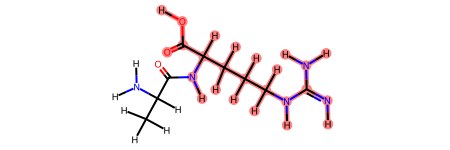

In [26]:
m

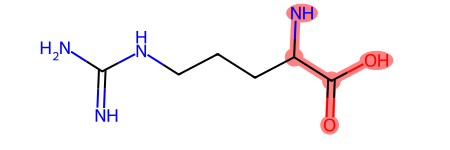

In [27]:
dehydrogen['Arginine']

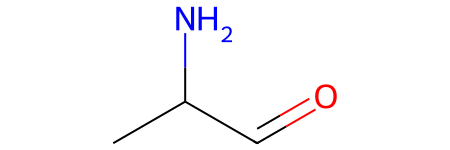

In [28]:
dehydroxy['Alanine']

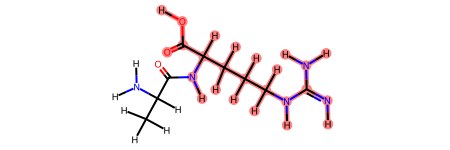

In [29]:
m

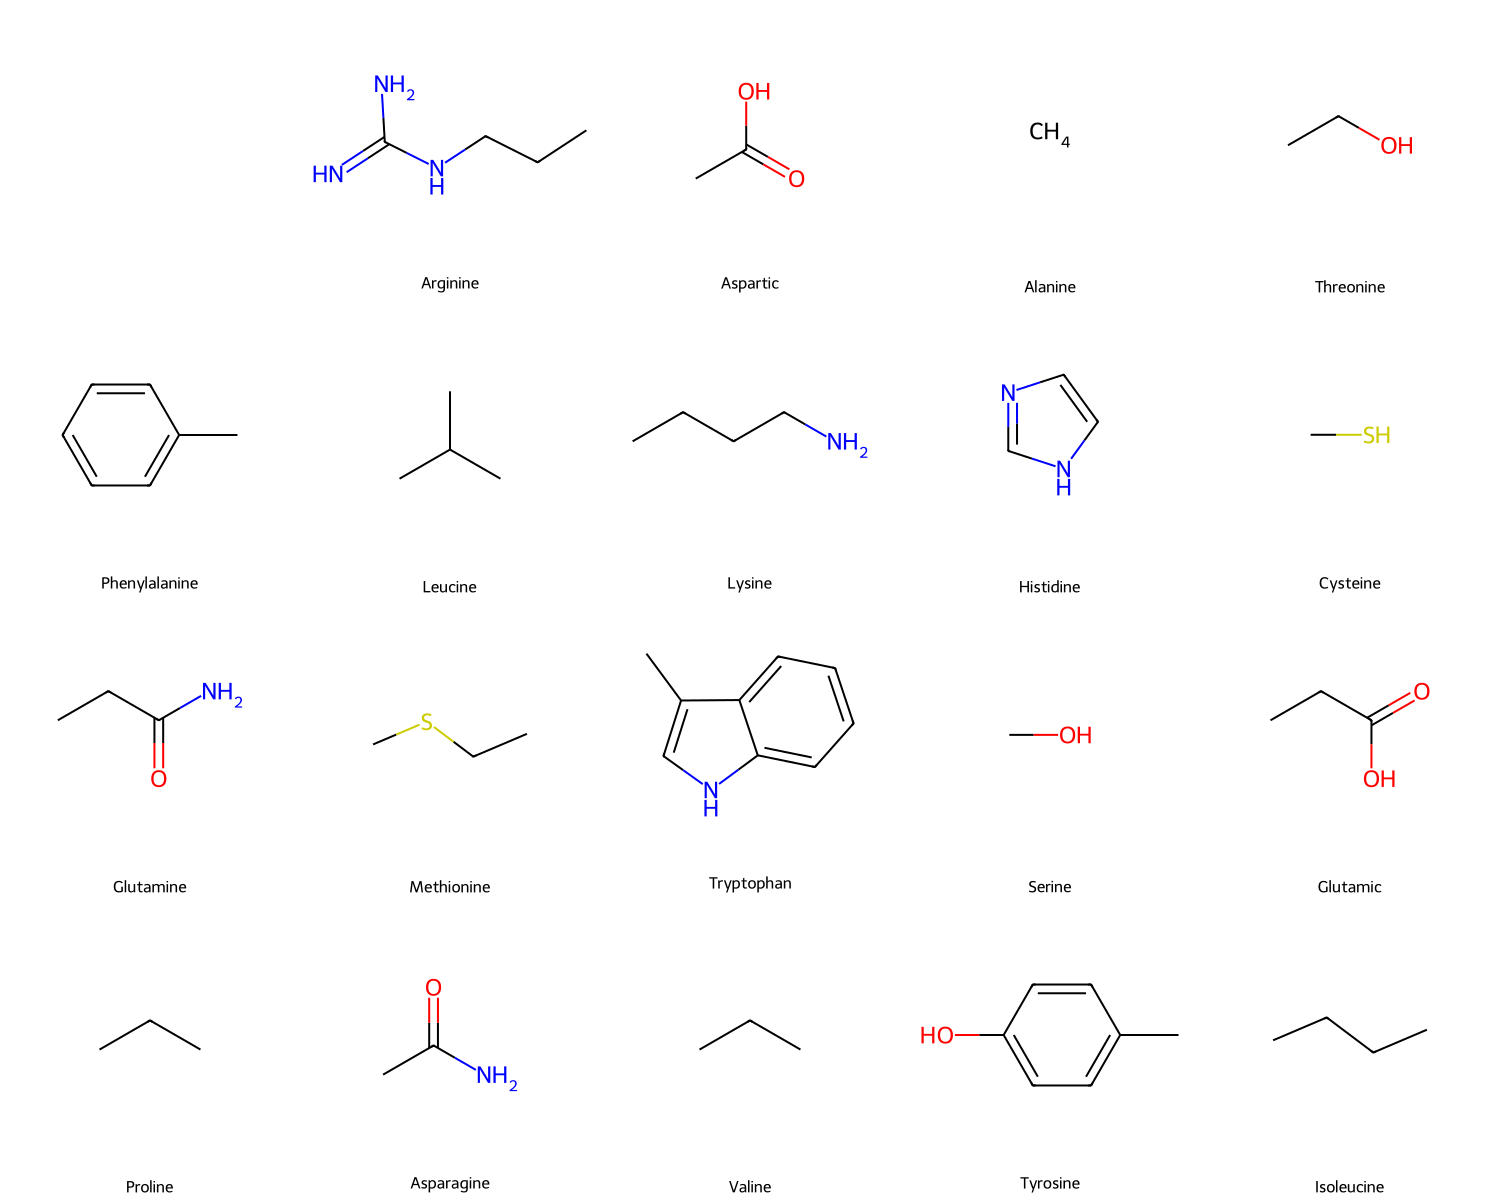

In [30]:
side_chains={k:AllChem.DeleteSubstructs(v,aa_mols['Glycine']) for k,v in aa_mols.items()}
# side_chains={k:Chem.ReplaceSubstructs(v,aa_mols['Glycine'],Chem.MolFromSmarts("*"))[0] for k,v in aa_mols.items()}
Draw.MolsToGridImage(side_chains.values(),molsPerRow=5, subImgSize=(300,300),legends=side_chains.keys())

In [31]:
interset=set(inter_dict['Glutamine-Phenylalanine']['idx'])
mol=Chem.AddHs(mols['Glutamine-Phenylalanine'])

pattchain1 = side_chains['Glutamine']
hitchain_ats1 = set(list(mol.GetSubstructMatch(pattchain1)))
pattchain2 = side_chains['Phenylalanine']
hitchain_ats2 = set(list(mol.GetSubstructMatch(pattchain2)))


pattAA1 = aa_mols['Glutamine']
hitAA_ats1 = set(list(mol.GetSubstructMatch(pattAA1)))
pattAA2 = aa_mols['Phenylalanine']
hitAA_ats2 = set(list(mol.GetSubstructMatch(pattAA2)))


if len(hitchain_ats1-set(interset))!=len(hitchain_ats1):
    print(hitchain_ats1)
    
if len(hitchain_ats2-set(interset))!=len(hitchain_ats2):
    print(hitchain_ats2)
    
if len(hitAA_ats1-set(interset))!=len(hitAA_ats1):
    print(hitAA_ats1)    
    
if len(hitAA_ats2-set(interset))!=len(hitAA_ats2):
    print(hitAA_ats2)  
    
    
    
    
    
dropOH={}
amino={}
for k,m in aa_mols.items():
    m=AllChem.AddHs(m)
    gly=set(sum(map(list,m.GetSubstructMatches(aa_mols['Glycine'])),[]))
    OHmatch=set(sum(map(list,m.GetSubstructMatches(Chem.MolFromSmarts("[OH]"))),[]))
    if k!='Proline':
        NH2match=set(sum(map(list,m.GetSubstructMatches(Chem.MolFromSmarts("[N;H2]"))),[]))
    else:
        NH2match=set(sum(map(list,m.GetSubstructMatches(Chem.MolFromSmarts("[N;H1]"))),[]))
    
    n=Chem.EditableMol(m)
    o=Chem.EditableMol(m)
    
    # Remove this one 
    if len(gly-OHmatch)!=len(gly):
        n.RemoveAtom(list(gly&OHmatch)[0])
        A = AllChem.RemoveAllHs(n.GetMol())
    # Remove one hydrogen if it is anything BUT proline
    if len(gly-NH2match)!=len(gly):
        
        o.RemoveAtom(list(gly&NH2match)[0])
        B = AllChem.RemoveAllHs(o.GetMol())
        amino[k]=list(gly&NH2match)[0]
    dropOH[k]=A
    
        

{2, 3, 4, 5, 6}


In [32]:
amino

{'Glycine': 4,
 'Arginine': 8,
 'Aspartic': 0,
 'Alanine': 2,
 'Threonine': 4,
 'Phenylalanine': 0,
 'Leucine': 5,
 'Lysine': 6,
 'Histidine': 0,
 'Cysteine': 0,
 'Glutamine': 6,
 'Methionine': 5,
 'Tryptophan': 0,
 'Serine': 0,
 'Glutamic': 0,
 'Proline': 7,
 'Asparagine': 5,
 'Valine': 4,
 'Tyrosine': 0,
 'Isoleucine': 5}

In [33]:
dropOH

{'Glycine': <rdkit.Chem.rdchem.Mol at 0x178b74ac0>,
 'Arginine': <rdkit.Chem.rdchem.Mol at 0x178b74b80>,
 'Aspartic': <rdkit.Chem.rdchem.Mol at 0x178b74a60>,
 'Alanine': <rdkit.Chem.rdchem.Mol at 0x178b74b20>,
 'Threonine': <rdkit.Chem.rdchem.Mol at 0x178b74be0>,
 'Phenylalanine': <rdkit.Chem.rdchem.Mol at 0x178b74c40>,
 'Leucine': <rdkit.Chem.rdchem.Mol at 0x178b74ca0>,
 'Lysine': <rdkit.Chem.rdchem.Mol at 0x178b74d00>,
 'Histidine': <rdkit.Chem.rdchem.Mol at 0x178b7c1c0>,
 'Cysteine': <rdkit.Chem.rdchem.Mol at 0x178b7c220>,
 'Glutamine': <rdkit.Chem.rdchem.Mol at 0x178b7c280>,
 'Methionine': <rdkit.Chem.rdchem.Mol at 0x178b7c2e0>,
 'Tryptophan': <rdkit.Chem.rdchem.Mol at 0x178b7c340>,
 'Serine': <rdkit.Chem.rdchem.Mol at 0x178b74d60>,
 'Glutamic': <rdkit.Chem.rdchem.Mol at 0x178b7c400>,
 'Proline': <rdkit.Chem.rdchem.Mol at 0x178b7c3a0>,
 'Asparagine': <rdkit.Chem.rdchem.Mol at 0x178b7c460>,
 'Valine': <rdkit.Chem.rdchem.Mol at 0x178b7c4c0>,
 'Tyrosine': <rdkit.Chem.rdchem.Mol at 0x1

In [34]:
Draw.MolsToGridImage(dipeptide_split['Glycine'].values())

NameError: name 'dipeptide_split' is not defined